<a href="https://colab.research.google.com/github/yingzibu/drug_design_JAK/blob/main/policy_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gym --quiet

In [10]:
import gym
env = gym.make('CartPole-v0')        # -- 1 importing the cartpole env
state1 = env.reset()
action = env.action_space.sample()   # -- 2 get a sample action from env
state, reward, done, info = env.step(action)
# 3 done = False, if pole stands; done = True if pole falls, end of episode

In [11]:
state, type(state), state.shape, action, type(action) # action only 1, 0 int

(array([-0.04079942,  0.23600493,  0.001489  , -0.32577908], dtype=float32),
 numpy.ndarray,
 (4,),
 1,
 int)

In [13]:
import gym
import numpy as np
import torch

l1 = 4                          # 1 input length of 4 for state vector
l2 = 150                        # 2 middle layer produces of vector of 150
l3 = 2                          # 3 action

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.Softmax()          # 4 produce the prob distribution of actions
)

learning_rate = 0.0009
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [22]:
pred = model(torch.from_numpy(state1).float())  # 1 produce prob of action
print(pred.detach().numpy())
action = np.random.choice(np.array([0,1]), p=pred.data.numpy())   # 2 sample act
# print(action, int(action))
action = int(action)
state2, reward, done, info = env.step(action)   # 3 update based on action

[0.49305975 0.5069403 ]


In [23]:
def discount_rewards(rewards, gamma=0.99):
    lenr = len(rewards)
    disc_return = torch.pow(gamma,torch.arange(lenr).float()) * rewards
    disc_return /= disc_return.max()
    return disc_return

In [24]:
def loss_fn(preds, r):
    return -1 * torch.sum(r * torch.log(preds))

episode: 100%|██████████| 1000/1000 [00:53<00:00, 18.70it/s]


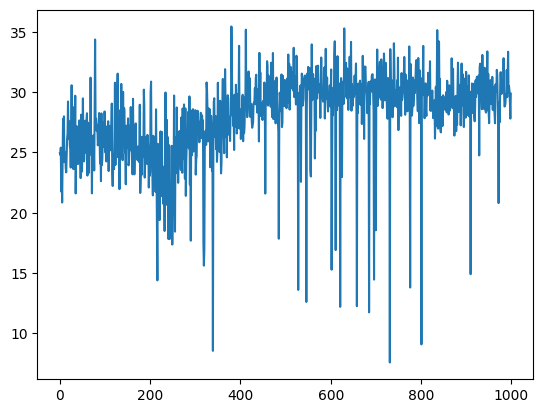

In [49]:
from tqdm import tqdm
MAX_DUR = 200
MAX_EPISODES = 1000
gamma = 0.99
score = []        # --1 keep track of the episode length over training time
losses = {}
for episode in tqdm(range(MAX_EPISODES), desc='episode'):
    curr_state = env.reset()
    done = False
    transitions = []             # --2 a list of state, action, rewards

    for t in range(MAX_DUR):     # --3 while in the episode
        # --4 get act probability
        act_prob = model(torch.from_numpy(curr_state).float())
        action = np.random.choice(np.array([0,1]), p=act_prob.data.numpy())
        prev_state = curr_state
        curr_state, _, done, info = env.step(int(action))
        transitions.append((prev_state, action, t+1))
        if done:
            break

    ep_len = len(transitions)
    score.append(ep_len)
    reward_batch = torch.Tensor([r for (s,a,r) in \
    transitions]).flip(dims=(0,))
    disc_rewards = discount_rewards(reward_batch)
    # rewards[episode] = disc_rewards
    state_batch = torch.Tensor(np.array([s for (s,a,r) in transitions]))
    action_batch = torch.Tensor([a for (s,a,r) in transitions])
    pred_batch = model(state_batch)
    prob_batch = pred_batch.gather(dim=1,
        index=action_batch.long().view(-1,1)).squeeze()
    loss = loss_fn(prob_batch, disc_rewards)
    losses[episode] = loss.detach().numpy()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(losses.keys(), list(losses.values()))

In [45]:

list(losses.values())

[array(26.256498, dtype=float32),
 array(26.165442, dtype=float32),
 array(31.265465, dtype=float32),
 array(28.620274, dtype=float32),
 array(23.90658, dtype=float32),
 array(24.440514, dtype=float32),
 array(21.346472, dtype=float32),
 array(25.015354, dtype=float32),
 array(25.27429, dtype=float32),
 array(26.302584, dtype=float32),
 array(22.182253, dtype=float32),
 array(26.951529, dtype=float32),
 array(26.904625, dtype=float32),
 array(24.721478, dtype=float32),
 array(23.154436, dtype=float32),
 array(27.434586, dtype=float32),
 array(25.504942, dtype=float32),
 array(25.458336, dtype=float32),
 array(26.089073, dtype=float32),
 array(29.573322, dtype=float32),
 array(26.446177, dtype=float32),
 array(22.175196, dtype=float32),
 array(20.280727, dtype=float32),
 array(27.98058, dtype=float32),
 array(20.806915, dtype=float32),
 array(23.36755, dtype=float32),
 array(23.68936, dtype=float32),
 array(22.017424, dtype=float32),
 array(23.68488, dtype=float32),
 array(19.810272, dt

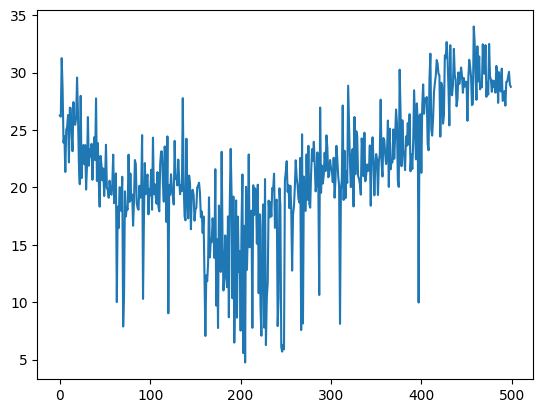

In [47]:
import matplotlib.pyplot as plt
